In [1]:
import pandas as pd

df = pd.read_csv("Tweets.csv")
df.shape

(14640, 15)

In [2]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [3]:
# removing unnecessary columns
df = df.drop(columns=["tweet_id", "airline", "name", "airline_sentiment_gold", "negativereason_gold", "tweet_coord", "tweet_created", "retweet_count", "user_timezone", "tweet_location"])

In [4]:
df
# airline-sentiment is the target variable

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,text
0,neutral,1.0000,NaN,NaN,@VirginAmerica What @dhepburn said.
1,positive,0.3486,NaN,0.0000,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,NaN,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Bad Flight,0.7033,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Can't Tell,1.0000,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...,...
14635,positive,0.3487,NaN,0.0000,@AmericanAir thank you we got on a different f...
14636,negative,1.0000,Customer Service Issue,1.0000,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,1.0000,NaN,NaN,@AmericanAir Please bring American Airlines to...
14638,negative,1.0000,Customer Service Issue,0.6659,"@AmericanAir you have my money, you change my ..."


In [5]:
df = df.drop(columns=["negativereason", "negativereason_confidence"])

In [6]:
# converting text into numerical vectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [7]:
label_encoder = LabelEncoder()

x = df["text"]
y = df["airline_sentiment"]
y = label_encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
# tokenizing
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# padding sequences to enseure equal length in all the texts
max_length = 100
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding="post", truncating="post")
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding="post", truncating="post")

In [12]:
# making the neural network
'''
working with : text
does order matter : yes

text -> need to use embeddings/tokenization

does model need to remember words :
    yes -> LSTM/GRU
    no -> dense layers

simple problem? => embedding + dense layer
complex problem? => LSTM + dense layer

here we can use embeddings because we need to establish relationship between words, 'good' and 'great' are similar in meaning

deciding layers:
    firstly, words (now integers) must be converted into vectors. hence, layer 1 = embedding
    secondly, vectors have to be put into an lstm to work on it. hence, layer 2 = LSTM
    lastly, we have to select one out of 3 outputs. hence, layer 3 = dense 
'''

model = Sequential([
    Embedding(input_dim=10000, output_dim=256, mask_zero=True),
    Bidirectional(LSTM(128)),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [14]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(x_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 56s 171ms/step - accuracy: 0.6900 - loss: 0.7394 - val_accuracy: 0.7973 - val_loss: 0.5143
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 50s 170ms/step - accuracy: 0.8728 - loss: 0.3392 - val_accuracy: 0.7981 - val_loss: 0.5205
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 52s 178ms/step - accuracy: 0.9361 - loss: 0.1899 - val_accuracy: 0.7644 - val_loss: 0.6360
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 52s 178ms/step - accuracy: 0.9576 - loss: 0.1292 - val_accuracy: 0.7810 - val_loss: 0.7672
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 52s 176ms/step - accuracy: 0.9746 - loss: 0.0798 - val_accuracy: 0.7776 - val_loss: 0.9002
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 51s 173ms/step - accuracy: 0.9821 - loss: 0.0523 - val_accuracy: 0.7734 - val_loss: 0.9778


In [15]:
results = model.evaluate(x_test_pad, y_test, verbose=0)
print(f"[test loss, test accuracy]: {results}")

[test loss, test accuracy]: [0.9829872846603394, 0.7708333134651184]


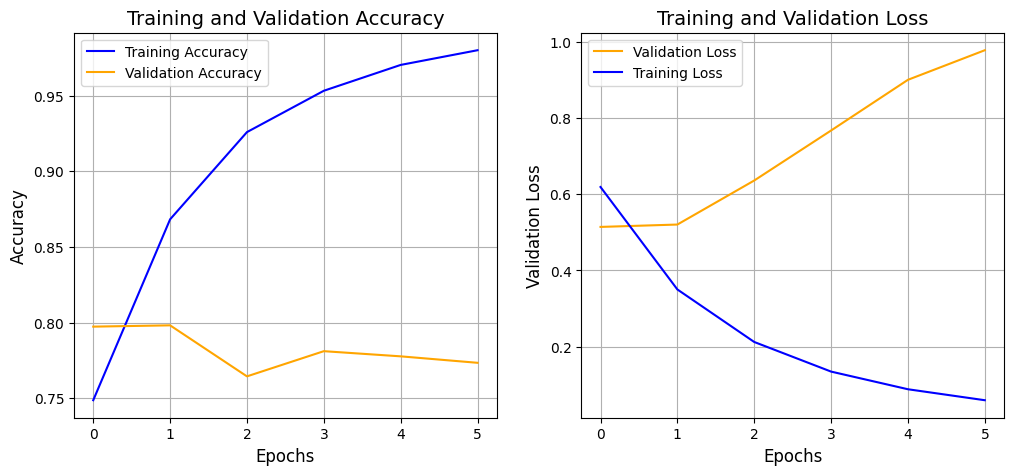

In [16]:
# visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.title("Training and Validation Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.legend()
plt.grid(True)